* To compare effect of viscosity in the mean current.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
import datetime
from salishsea_tools import (viz_tools,tidetools,nc_tools,stormtools)
import matplotlib.gridspec as gridspec
import numpy.ma as ma
import os
import glob
import codar

In [2]:
## load different bathys
grid2 = nc.Dataset('/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X={};Y={};bathy={};grids = [grid2,grid6]
for grid in grids:
    X[grid] = grid.variables['nav_lon'][:, :]
    Y[grid] = grid.variables['nav_lat'][:, :]
    bathy[grid] = grid.variables['Bathymetry'][:, :]

In [3]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st = 3

In [4]:
def plot_all(nc1,nc2,string1,string2,grid1,grid2,d,
             cmin=0, cmax = 0.3,lonmax =-123., lonmin =-123.7, latmax =49.35, latmin = 48.9 ):  
    ncs = [nc1,nc2]
    strings = [string1,string2]
    dep = nc1.variables['depthu']
    types = ['{st} at {h:.2f} m'.format(st = strings[0],h=dep[d]),\
             '{st} at {h:.2f} m'.format(st = strings[1],h=dep[d])]
    grids = [grid1,grid2]
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={} 
    fig, axs = plt.subplots(1,3,figsize = (21,6))
    for nc,tp,grid, ax in zip(ncs,types, grids,axs[:2]):
        u_6= nc.variables['vozocrtx']
        v_6 = nc.variables['vomecrty']
        u_mean6 = np.nanmean(u_6, axis = 0)
        v_mean6 = np.nanmean(v_6, axis = 0)

        u_m[tp] =u_mean6[d,:,:]
        v_m[tp] =v_mean6[d,:,:]
        ##unstagger u v
        U_m[tp],V_m[tp] = viz_tools.unstagger(u_m[tp],v_m[tp])
        #rotate
        theta = np.pi*29/180
        U_m[tp] = U_m[tp]*np.cos(theta) - V_m[tp]*np.sin(theta)
        V_m[tp] = U_m[tp]*np.sin(theta) +V_m[tp]*np.cos(theta)
        ##mask
        U_m[tp]=np.ma.masked_values(U_m[tp],0)
        V_m[tp]=np.ma.masked_values(V_m[tp],0)
        lon = X[grid6][380:479,240:319]
        lat = Y[grid6][380:479,240:319]
        if nc ==uv_hv: ## my different concatentating parts 
            UU = U_m[tp][:99,:79]
            VV = V_m[tp][:99,:79]
        else:
            UU = U_m[tp]
            VV = V_m[tp]

        mesh=ax.pcolormesh(lon, lat,np.sqrt(UU**2+VV**2), cmap='Reds', vmin=cmin, vmax=cmax)
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Total Velocity[m/s]', fontsize = 20)
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
        quiver = ax.quiver(lon[::st,::st], lat[::st,::st], UU[::st,::st], VV[::st,::st],\
                            pivot='mid',scale=2.5,width=0.005, color='black')
        ax.quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                                    fontproperties = {'size': '15'})
        viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
        viz_tools.plot_coastline(ax, grid, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_title(tp,fontsize = 20)
    ##diff
    if nc2 ==uv_hv:
        UU = U_m[types[1]][:99,:79]
        VV = V_m[types[1]][:99,:79]
    else:
        UU = U_m[types[1]]
        VV = V_m[types[1]]
    mesh=axs[2].pcolormesh(lon, lat,\
                        np.sqrt(U_m[types[0]]**2+V_m[types[0]]**2) \
                        -np.sqrt(UU**2+VV**2), \
                        cmap='bwr', vmin=-0.1, vmax=0.1)
    cbar = plt.colorbar(mesh, ax=axs[2])
    cbar.set_label('Total Velocity[m/s]', fontsize = 20)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k', fontsize = 20)  
    quiver = axs[2].quiver(lon[::st,::st], lat[::st,::st], \
                           U_m[types[0]][::st,::st]-UU[::st,::st],\
                       V_m[types[0]][::st,::st]-VV[::st,::st],pivot='mid',\
                           scale=2.5,width=0.005, color='black')
    axs[2].quiverkey(quiver,-123.1,49.15, 0.1, '0.1 m/s', coordinates='data', color='black', labelcolor='black',\
                                    fontproperties = {'size': '15'})
    axs[2].set_title(types[1]+'-'+types[0], fontsize = 20)
    viz_tools.plot_land_mask(axs[2],grid6,coords='map',xslice=x,yslice=y,color='burlywood')
    viz_tools.plot_coastline(axs[2], grid6, coords = 'map', isobath = 4,color = 'DarkViolet')
    for ax in axs:
        ax.plot(lon[20,:],lat[20,:],'b-') ##lower blue line
        ax.plot(lon[40,:],lat[40,:],'b-')##middle blue line
        ax.plot(lon[60,:],lat[60,:],'b-')##upper blue line
        ax.set_xlim(lonmin,lonmax)
        ax.set_ylim(latmin, latmax)     
        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20)
        ax.set_xlabel('Longitude',fontsize=20)
        ax.set_ylabel('Latitude',fontsize=20)
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    
    return fig

In [5]:
def plot_vertical_velocity(nc1,nc2,string1,string2,ind_dep,ve = 'u',cmin = -0.2,cmax = 0.2):
    fig, axs = plt.subplots(1,2,figsize = (14,4))
    cmap  = plt.get_cmap('jet')
    ncs = [nc1,nc2]
    strings = [string1,string2]
    dep = uv.variables['depthu']
    types = ['mean {u} velocity of {st} case'.format(u=ve,st=strings[0]),\
             'mean {u} velocity of {st} case'.format(u=ve,st=strings[1])]
    u_m = {};v_m = {}; U_m = {};V_m = {};lon = {};lat ={};UU_m={}
    for nc,tp, ax in zip(ncs,types,axs):
        u_6= nc.variables['vozocrtx']
        v_6 = nc.variables['vomecrty']
        u_mean6 = np.nanmean(u_6, axis = 0)
        v_mean6 = np.nanmean(v_6, axis = 0)
        ##unstagger u v
        U_m[tp],V_m[tp] = viz_tools.unstagger(u_mean6,v_mean6)
        #rotate
        theta = np.pi*29/180
        U_m[tp] = U_m[tp]*np.cos(theta) - V_m[tp]*np.sin(theta)
        V_m[tp] = U_m[tp]*np.sin(theta) +V_m[tp]*np.cos(theta)
        ##mask
        U_m[tp]=np.ma.masked_values(U_m[tp],0)
        V_m[tp]=np.ma.masked_values(V_m[tp],0)
        lon = X[grid6][380:479,240:319]
        lat = Y[grid6][380:479,240:319]
        if nc ==uv_hv: ## my different concatentating parts 
            UU = U_m[tp][:,:99,:79]
            VV = V_m[tp][:,:99,:79]
        else:
            UU = U_m[tp]
            VV = V_m[tp]
        if ve =='u':
            mesh = ax.contourf(lon[ind_dep,:],dep[:],
            UU[:,ind_dep,:], np.arange(cmin, cmax, 0.03),cmap=cmap)
        elif ve =='v':
            mesh = ax.contourf(lon[ind_dep,:],dep[:],
            VV[:,ind_dep,:], np.arange(cmin, cmax, 0.03),cmap=cmap)
        elif ve =='total':
            mesh = ax.contourf(lon[ind_dep,:],dep[:],
            np.sqrt(UU[:,ind_dep,:]**2+VV[:,ind_dep,:]**2), np.arange(0, 0.3, 0.03),cmap=cmap)
        plt.setp(ax.get_xticklabels(), fontsize=15)
        plt.setp(ax.get_yticklabels(), fontsize=15)
        cbar = fig.colorbar(mesh, ax=ax)
        cbar.set_label('[m/s]', fontsize = 15)
        ax.set_title(tp, fontsize = 15)
        ax.set_xlim([lon[ind_dep,0], lon[ind_dep,-1]])
        ax.set_ylim([dep[-8], 0])
        ax.set_ylabel('Depth [m]', fontsize = 15)
    return fig

# 1e-05 viscosity+bathy6 vs 1e-04+bathy6 for a month

* Difference only in viscosity

In [6]:
uv = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/OctMeanCurrent/codar_all_large.nc'); 
uv_hv = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Bathy6HigherVisco/codar_highervisBathy6.nc')

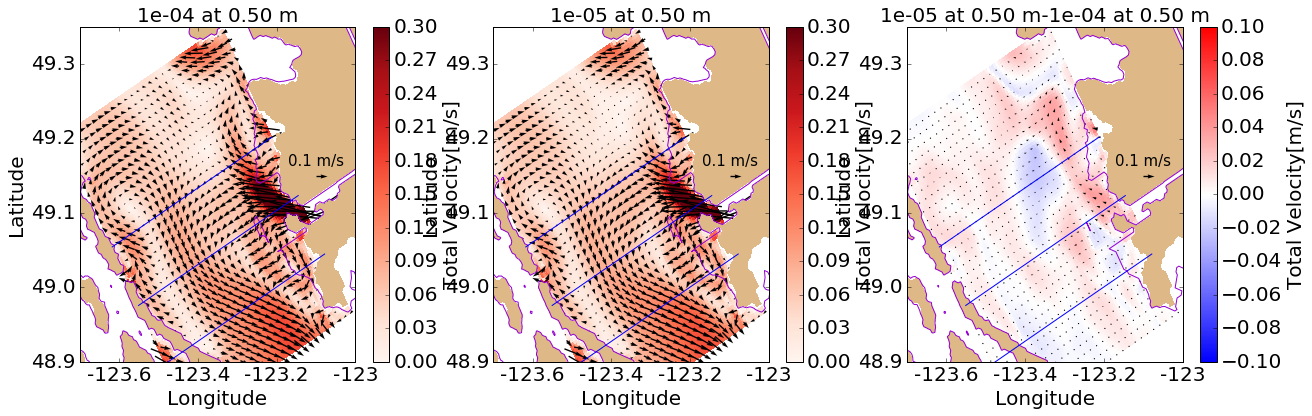

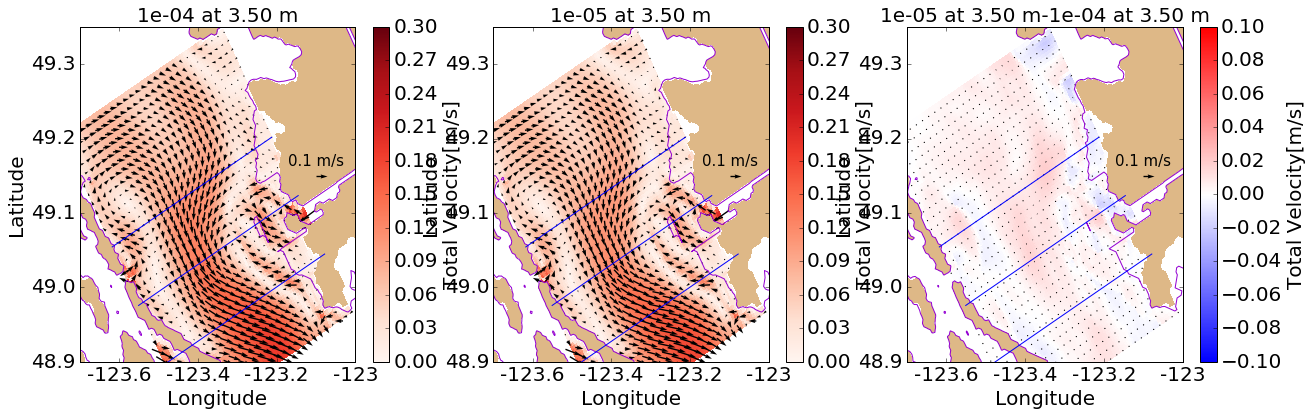

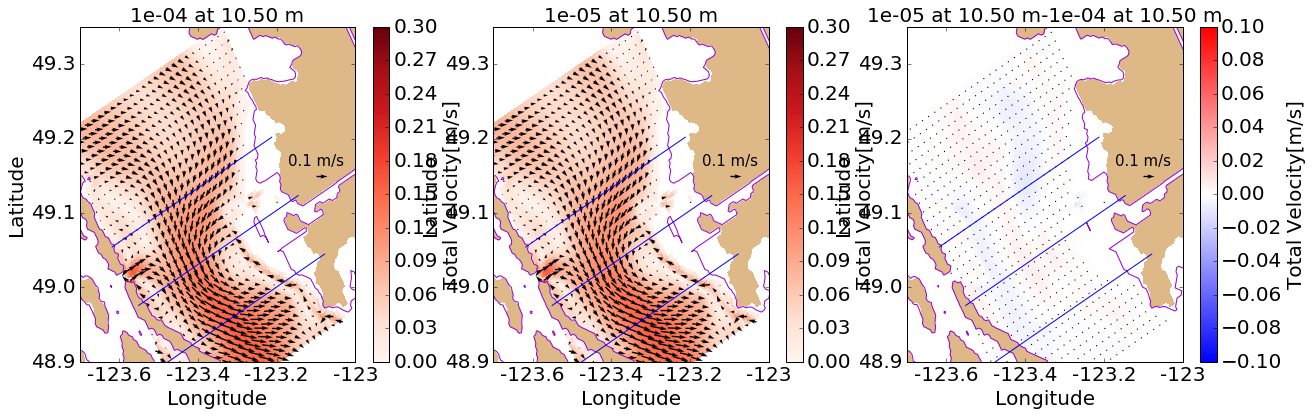

In [7]:
fig = plot_all(uv,uv_hv,'1e-04','1e-05',grid6,grid6,0)
fig = plot_all(uv,uv_hv,'1e-04','1e-05',grid6,grid6,3)
fig = plot_all(uv,uv_hv,'1e-04','1e-05',grid6,grid6,10)

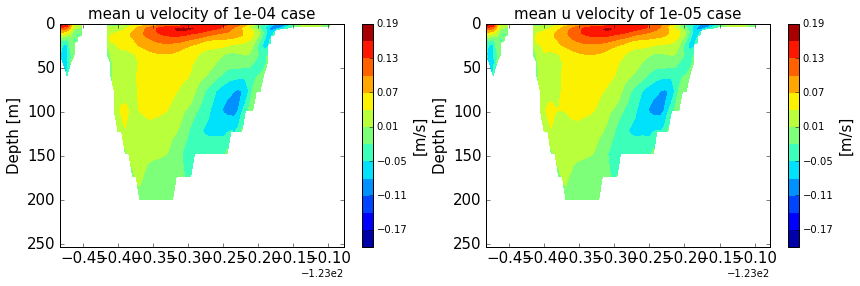

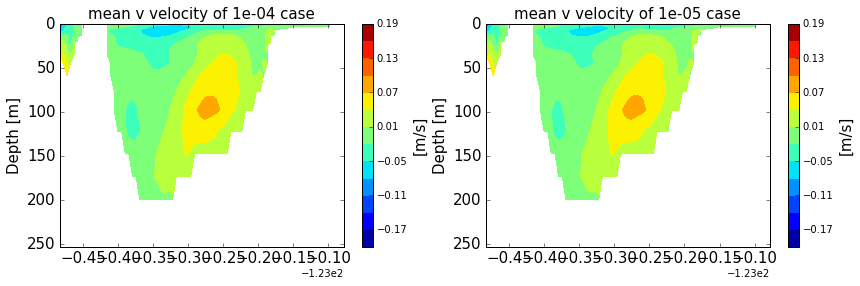

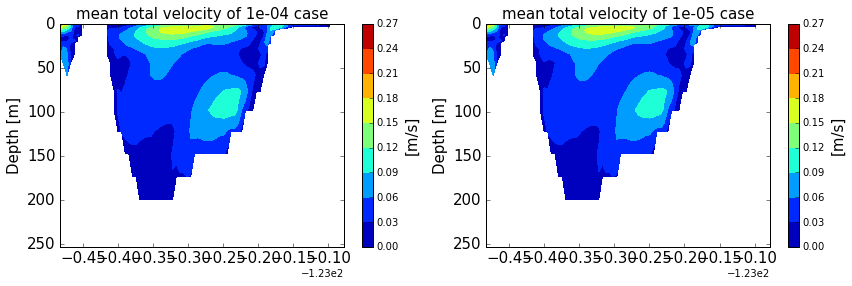

In [8]:
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',20,'u')
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',20,'v')
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',20,'total')

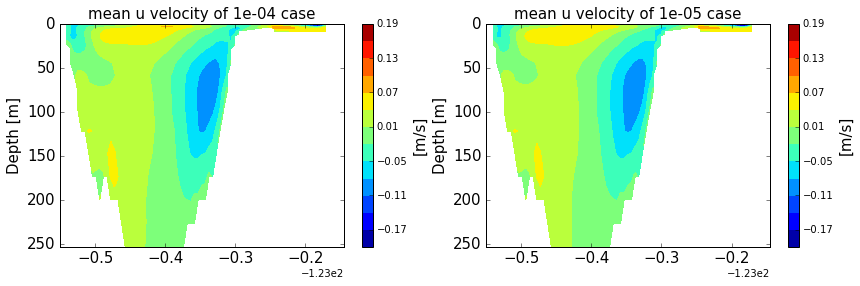

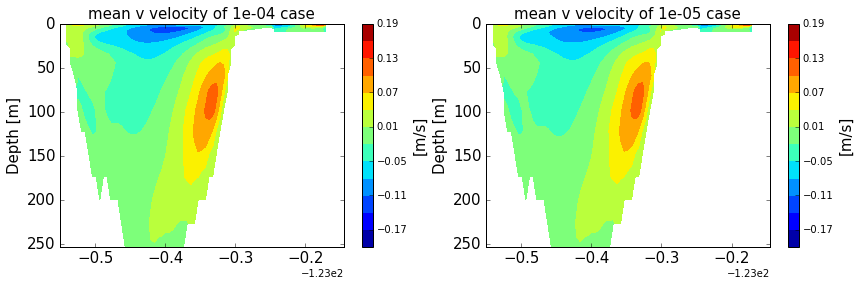

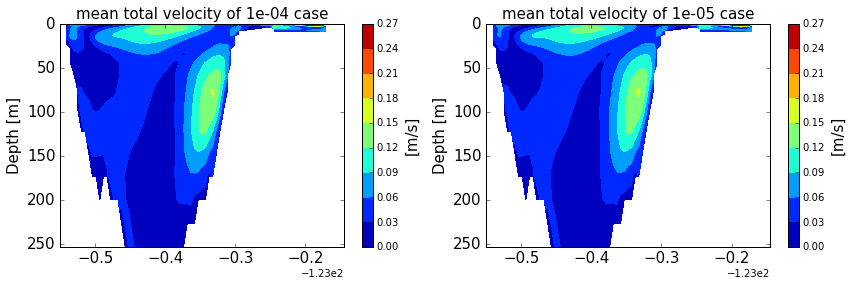

In [9]:
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',40,'u')
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',40,'v')
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',40,'total')

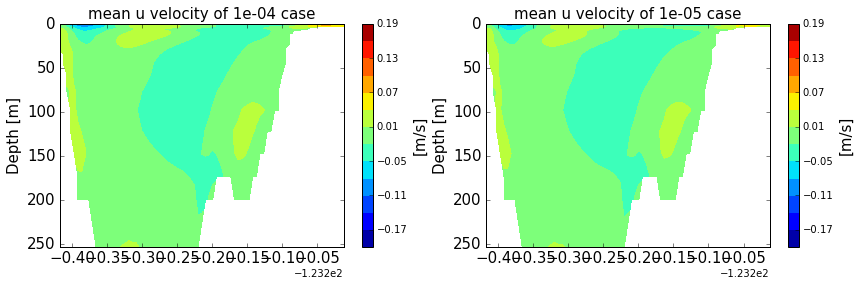

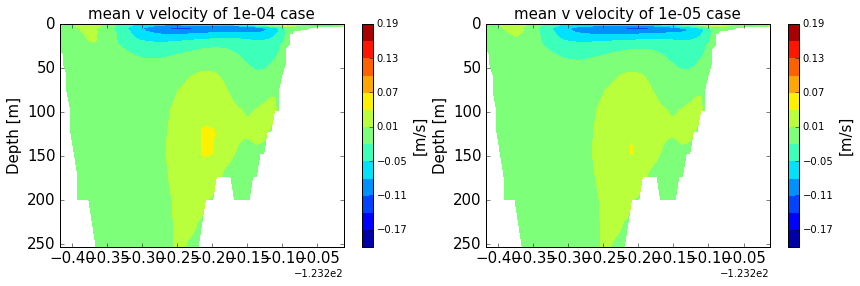

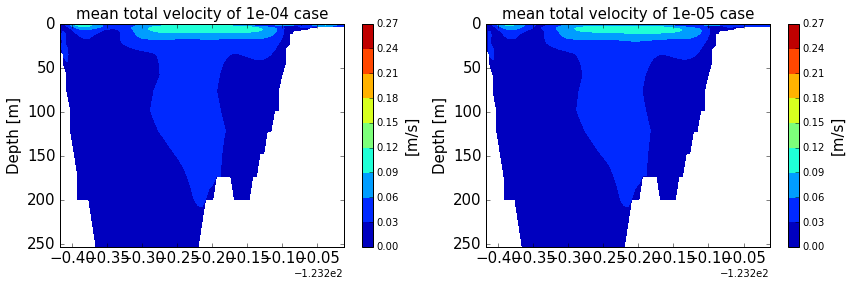

In [10]:
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',60,'u')
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',60,'v')
fig = plot_vertical_velocity(uv,uv_hv,'1e-04','1e-05',60,'total')

# 1e-04 viscosity+bathy2 vs 1e-04 viscosity+bathy6

In [11]:
uv_bathy2 = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Bathy2HigherVisco/codar_highervis.nc')

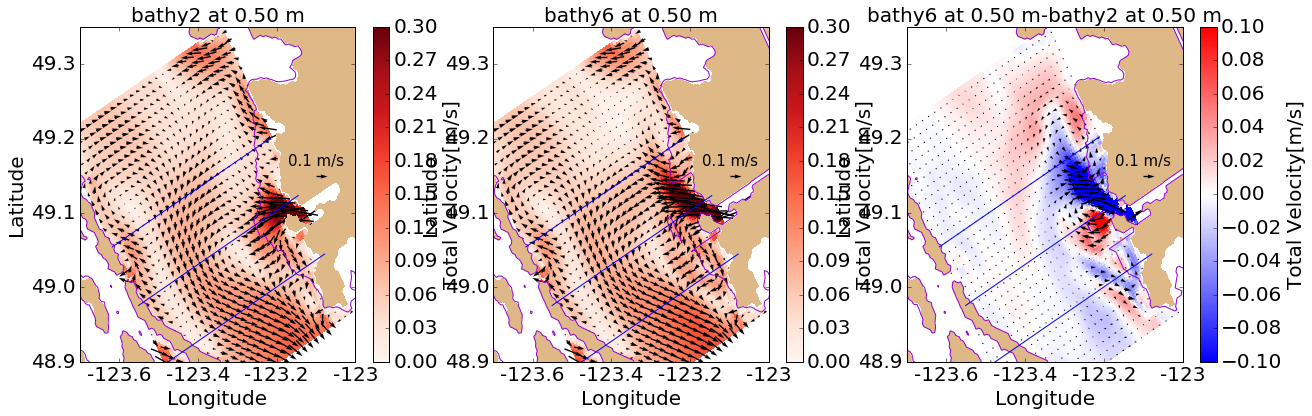

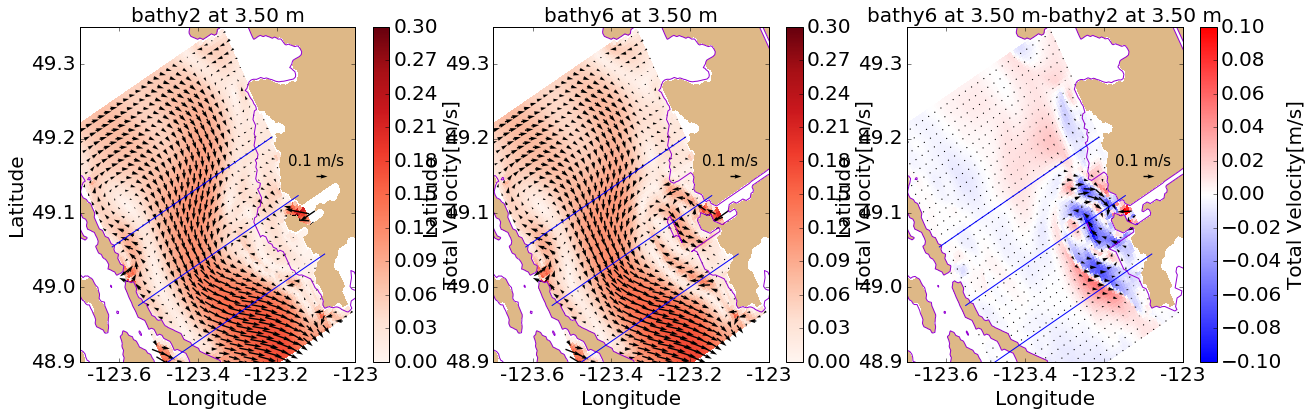

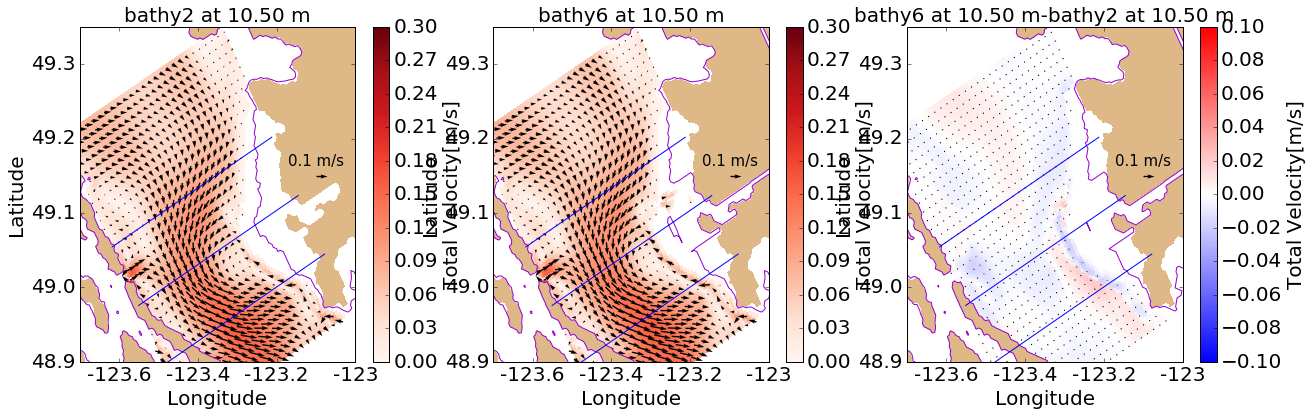

In [12]:
fig = plot_all(uv_bathy2,uv_hv,'bathy2','bathy6',grid2,grid6,0)
fig = plot_all(uv_bathy2,uv_hv,'bathy2','bathy6',grid2,grid6,3)
fig = plot_all(uv_bathy2,uv_hv,'bathy2','bathy6',grid2,grid6,10)

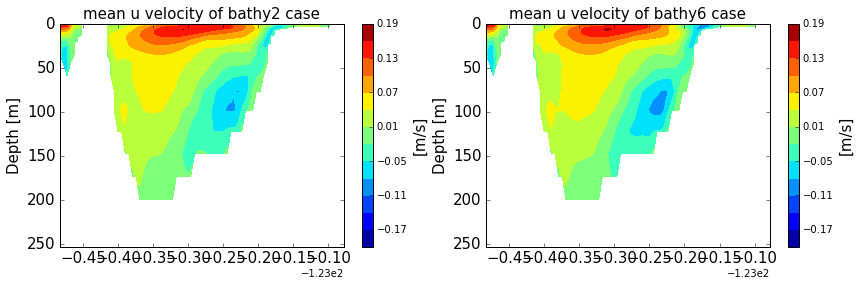

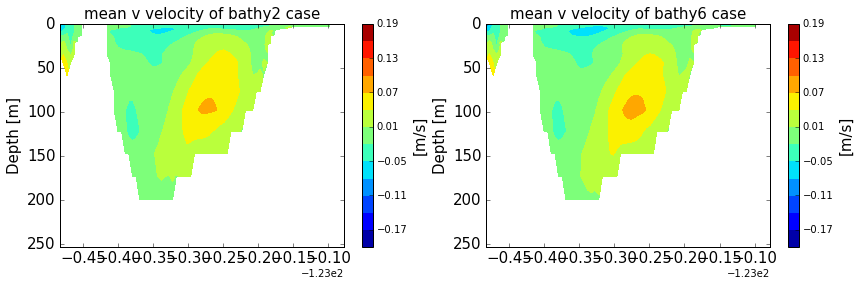

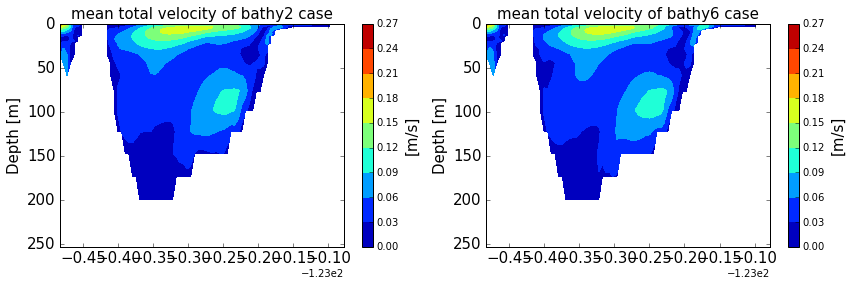

In [13]:
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',20,'u')
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',20,'v')
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',20,'total')

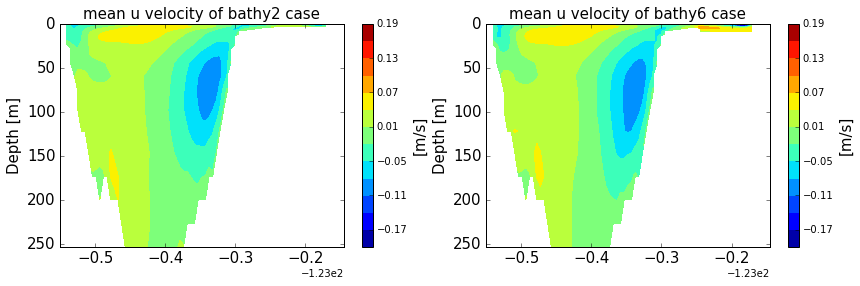

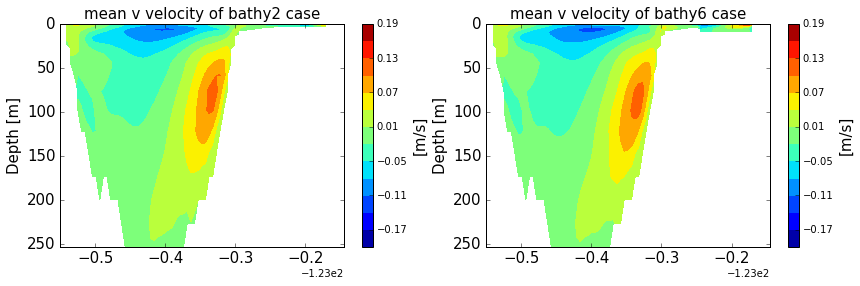

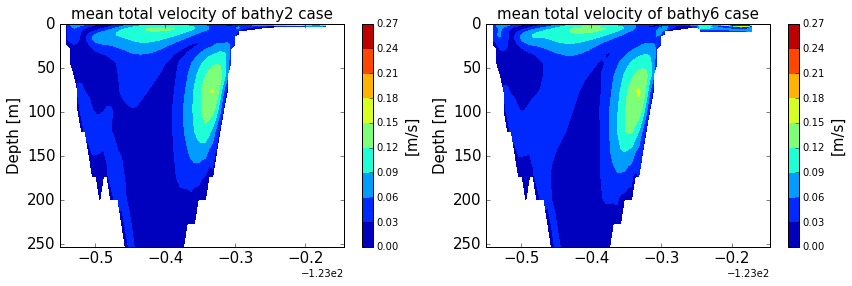

In [ ]:
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',40,'u')
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',40,'v')
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',40,'total')

In [ ]:
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',60,'u')
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',60,'v')
fig = plot_vertical_velocity(uv_bathy2,uv_hv,'bathy2','bathy6',60,'total')